In [1]:
from fileData import *
code_path = ".."
requiredFields = ['FileCount', 'AvgFileSize', 'BufSize', 'Bandwidth', 'AvgRtt', 'CC_Level', 'P_Level', 'PP_Level',
                  'numActiveCores', 'frequency', 'TotalAvgTput', 'TotalEnergy', 'DataTransferEnergy']
LabelName = 'TotalAvgTput'
fileData_chameleon = ReadFile(code_path + '/Dataset/Chameleon_Combined_all.csv', requiredFields)
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
import cmocean

In [2]:
# @Author: jamil
# @Date:   2021-06-11T16:50:09-05:00
# @Last modified by:   jamil
# @Last modified time: 2021-07-04T14:44:57-05:00


"""
History log are grouped based on 5 fields ('FileCount', 'AvgFileSize','BufSize', 'Bandwidth', 'AvgRtt')
and this tuple we will denote as key, group key, group tuple
"""


import math
import random
import numpy as np
import re
import sys
import pandas as pd
from collections import Counter
from collections import deque

"""
input: a pandas dataframe and a list of fields that needs to be extracted from the csv
output: pandas dataframe from the csv with onlt the input list of required fields
"""

def extractRequiredColumn(df,requiredFields):
    return df[df.columns[df.columns.isin(requiredFields)]]

"""
input: a directory where the csv files resides could handle multiple csv files location
output: concatenated pandas datframe (in case of multiple location) or pandas dataframe
"""
def load_dataset_from_file(dataset_file_location):
    result_df=pd.read_csv(dataset_file_location[0])
    if len(dataset_file_location)>1:
        for i in range(1,len(dataset_file_location)):
            temp_df=pd.read_csv(dataset_file_location[i])
            result_df=pd.concat([result_df, temp_df], axis=0, join='inner')
    return result_df

"""
log class to store each row of the history log (only required fields) as a log
"""

class Log:
    def __init__(self, serialNo, values):
        self.serialNo = serialNo
        self.values = values
        self.ranges=[]
        self.names = ['FileCount','AvgFileSize','BufSize','Bandwidth','AvgRtt','CC_Level','P_Level','PP_Level','numActiveCores','frequency','TotalAvgTput','TotalEnergy','DataTransferEnergy']

    def __str__(self):
        result = ""
        for i in range(len(self.names)):
            result += "%d %s:%.2f" % (self.serialNo, self.names[i], self.values[i])
        return result

"""
Readfile Class to read a history log (.csv) and group logs based on ['FileCount', 'AvgFileSize','BufSize', 'Bandwidth', 'AvgRtt']
and provide group and history log as a whole statistics
"""
class ReadFile:
    def __init__(self,
                dataset_file_location,requiredFields):
        self.logs=[]
        self.dataset=pd.read_csv(dataset_file_location)
        self.requiredData=extractRequiredColumn(self.dataset,requiredFields)
        for index, row in self.requiredData.iterrows():
            self.logs.append(
            Log(index,[row['FileCount'], row['AvgFileSize'],row['BufSize'],row['Bandwidth'],row['AvgRtt'],row['CC_Level'],row['P_Level'],row['PP_Level'],row['numActiveCores'],row['frequency'],row['TotalAvgTput'],row['TotalEnergy'],row['DataTransferEnergy']]))#'P_Level','PP_Level','numActiveCores','frequency','TotalAvgTput'
        self.grouped_df=self.requiredData.groupby(['FileCount', 'AvgFileSize','BufSize', 'Bandwidth', 'AvgRtt'])
        self.map_for_tuple_to_throughput=dict()
        self.map_for_group_key_to_all_logs=dict()
        self.map_for_group_key_to_test_logs=dict()
        for key,item in self.grouped_df:
            key_group_test_logs=[]
            a_group=self.grouped_df.get_group(key)
            group_max_throughput=a_group['TotalAvgTput'].max()
            self.map_for_tuple_to_throughput[key]=group_max_throughput
            number_of_rows=a_group.shape[0]
            selected_no_test_rows=math.ceil(number_of_rows*1)  #30% is test data
            a_group_test=a_group.sample(n=selected_no_test_rows)
            for index, row in a_group_test.iterrows():
                key_group_test_logs.append(Log(index,[row['FileCount'], row['AvgFileSize'],row['BufSize'],row['Bandwidth'],row['AvgRtt'],row['CC_Level'],row['P_Level'],row['PP_Level'],row['numActiveCores'],row['frequency'],row['TotalAvgTput'],row['TotalEnergy'],row['DataTransferEnergy']]))
            self.map_for_group_key_to_test_logs[key]=key_group_test_logs

    """
    return_map_for_tuple_to_throughput() returns a dictionary for
    each group (key) of logs and max throughput for that group
    """
    def return_map_for_tuple_to_throughput(self):
        return self.map_for_tuple_to_throughput

    """
    get_grouped_df() returns a generic.DataFrameGroupBy object which needs to be accessed
    by group keys
    """
    def get_grouped_df(self):
        return self.grouped_df
    """
    return_group_specific_test_logs() returns a list of log entries associated with
    that particular group keys
    """
    def return_group_specific_test_logs(self,group_key):
        return self.map_for_group_key_to_test_logs[group_key]

"""
function takes a dataframe and max throughput and returns 
max throughput corresponding CC,P and PP level as a tuple
"""

def max_throughput_to_parameter(df, max_throughput):
    for index, row in df.iterrows():
        if row['TotalAvgTput']==max_throughput:
            return (row['CC_Level'],row['P_Level'],row['PP_Level'])
        else:
            continue
    

    
"""
environmentGroup Class to build the gym environment on the history log
input: filedata_grouped_df a pandas.core.groupby.generic.DataFrameGroupBy object
       groupKey a tuple of 'FileCount', 'AvgFileSize','BufSize', 'Bandwidth', 'AvgRtt's
"""



class environmentGroup:
    def __init__(self,
                filedata_grouped_df,groupKey):
                self.logs=[]
                self.grouped_df=filedata_grouped_df
                self.a_group=self.grouped_df.get_group(groupKey)
                self.group_max_throughput=self.a_group['TotalAvgTput'].max()
                self.number_of_rows=self.a_group.shape[0]
                self.group_max_throughput_parameters=max_throughput_to_parameter(self.a_group,self.group_max_throughput)
                selected_no_test_rows=math.ceil(self.number_of_rows*1)  #30% is test data
                a_group_test=self.a_group.sample(n=selected_no_test_rows)
                self.group_identification=groupKey
                for index, row in a_group_test.iterrows():
                    self.logs.append(Log(index,[row['FileCount'], row['AvgFileSize'],row['BufSize'],row['Bandwidth'],row['AvgRtt'],row['CC_Level'],row['P_Level'],row['PP_Level'],row['numActiveCores'],row['frequency'],row['TotalAvgTput'],row['TotalEnergy'],row['DataTransferEnergy']]))
                self.group_from_grouped_df=self.a_group.groupby(['CC_Level','P_Level','PP_Level'])#,'numActiveCores','frequency'
                self.grouping_list_name=['CC_Level','P_Level','PP_Level']
                self.action_list=[]
                self.state_list=[]
                for key in self.group_from_grouped_df.groups.keys():
                    self.action_list.append(key)
                    self.state_list.append([groupKey[0],groupKey[1],groupKey[2],groupKey[3],groupKey[4],key[0],key[1],key[2]]) #,key[3],key[4]
    """
    input:
    output:provides the maximum throughput for the class groupkey
    """

    def group_maximum_throughput(self):
        return self.group_max_throughput

    """
    input:
    output:provides the total number of logs for the class groupkey
    """
    def total_number_of_logs(self):
        return self.number_of_rows
    """
    input:
    output:provides the total dataframe for the class groupkey
    """

    def return_a_group(self):
        return self.a_group

    """
    input:
    output:provides the group of groups (pp,p,cc) for the class groupkey
    """

    def return_group_from_grouped_df(self):
        return self.group_from_grouped_df
    """
    input:
    output:provides the group of groups (pp,p,cc) name for the class groupkey
    """

    def return_grouping_list_name(self):
        return self.grouping_list_name

    """
    input:
    output:provides the action list  for the class groupkey
    """
    def return_action_list(self):
        return self.action_list

    """
    input:
    output:provides the state list  for the class groupkey
    """
    def return_state_list(self):
        return self.state_list

    """
    input: takes a tuple of action key ('CC_Level','P_Level','PP_Level')
    output:provides the list of all the throughputs for the class groupkey and
           action key ('CC_Level','P_Level','PP_Level')
    """
    def return_group_key_throughput(self,search_key):
        result_throughput=[]
        log_group=self.group_from_grouped_df.get_group(search_key)
        for index, row in log_group.iterrows():
            result_throughput.append(row['TotalAvgTput'])
        return result_throughput
    """
    input: 
    output:provides the group key as tuple ('FileCount', 'AvgFileSize','BufSize', 'Bandwidth', 'AvgRtt')
    """
    def return_group_identification(self):
        return self.group_identification
    
    """
    input: 
    output:provides the group max throughput corresponding CC,P and PP level as a tuple
    """
    def return_group_max_throughput_parameters(self):
        return self.group_max_throughput_parameters
    
    
import gym
from gym import spaces
import numpy as np
import random

THRUPUT_PENALTY = -0.3 # hyperparameter
MAX_TIMESTEPS = 100
MAX_ACTIONS = 127
class NetEnvironment(gym.Env):
    metadata = {'render.modes': []}
    def __init__(self, environment_group):
        self.environment_group = environment_group
        self.states = environment_group.return_state_list()
        self.actions = environment_group.return_action_list()
        self.max_throughput = environment_group.group_maximum_throughput()
        self.max_throughput_parameters=environment_group.return_group_max_throughput_parameters()
        self.environment_group_identification=environment_group.return_group_identification()
        self.observation_space = spaces.Box(low=0, high=np.inf, shape=(8,), dtype=np.float32)
        self.action_space = spaces.Discrete(len(self.actions))
        self.max_timesteps = MAX_TIMESTEPS
        self.time = 0
        self.b = THRUPUT_PENALTY
        self.prev_throughput = -1.
        self.current_observation = np.asarray(self.states[0])
        self.obs_shape=(8,)

    def reset(self):
        self.time = 0
        self.prev_throughput = -1
        self.current_observation = self.states[0]
        return np.asarray(self.current_observation)

    def step(self, action):
        action = self.actions[action]
        # action = tuple(action)
        # get throughputs
        throughputs = self.environment_group.return_group_key_throughput(action)
        cur_throughput = random.choice(throughputs)
        # if cur_throughput < self.prev_throughput:
        #     reward = self.b
        # else:
        reward = cur_throughput / self.max_throughput
        self.prev_throughput = cur_throughput

        self.time += 1
        if self.max_timesteps <= self.time:
            done = True
        else:
            done = False

        info = {'time': self.time, 'max_time': self.max_timesteps}
        self.current_observation[-3:] = action
        return np.asarray(self.current_observation), reward, done, info

    def get_actions(self):
        return self.actions

    def get_states(self):
        return self.states

    def get_max_throughput(self):
        return self.max_throughput

    def get_time(self):
        return self.time

    def render(self):
        pass

In [3]:
optimal_throughput_dictionary_chameleon = fileData_chameleon.return_map_for_tuple_to_throughput()
filedata_grouped_df = fileData_chameleon.get_grouped_df()
# print(type(filedata_grouped_df))
filedata_keys=[key for key, _ in filedata_grouped_df]
# print(filedata_keys,len(filedata_keys))
a_group=filedata_grouped_df.get_group(filedata_keys[0])
# print(type(a_group))
print(a_group.shape[0])

857


2
(32, 222.6392977, 40, 10, 60)


(array([1]), [Text(1, 0, '(9, 1, 19)')])

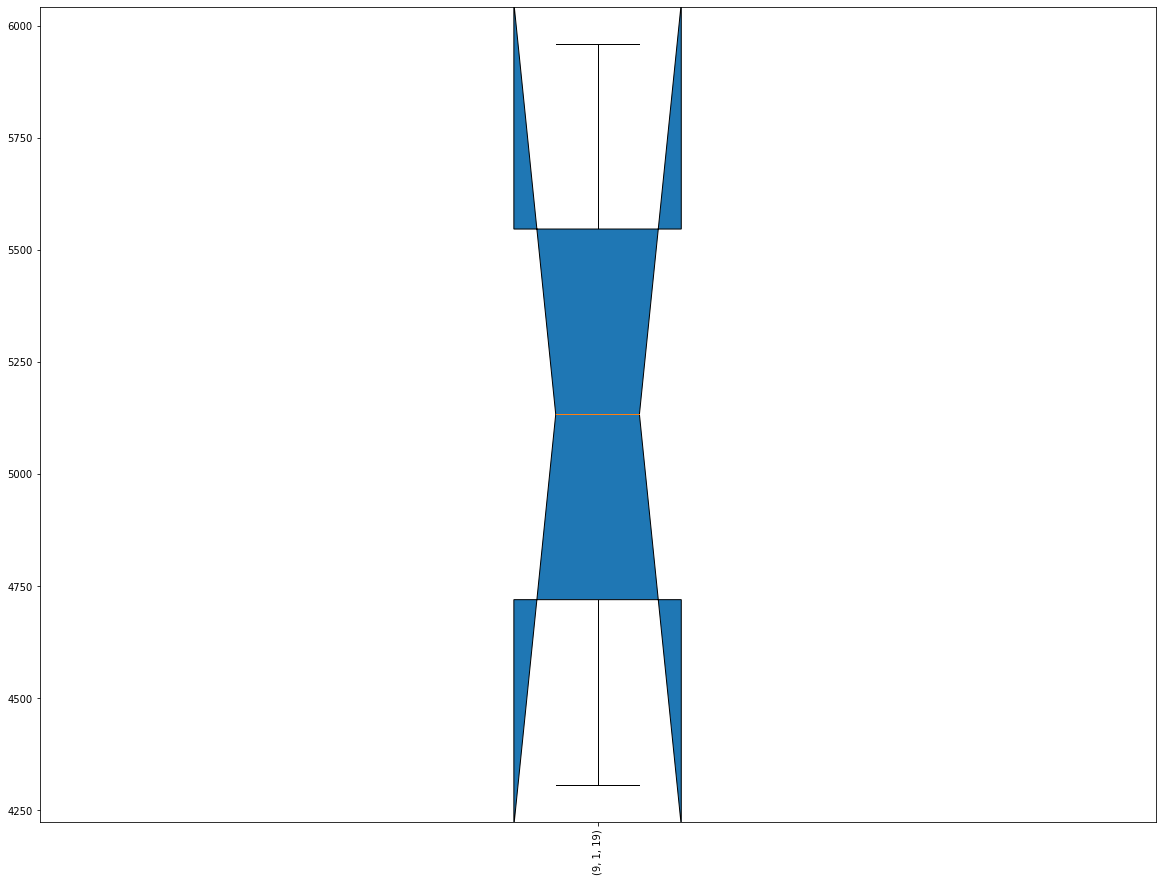

In [11]:
selectedgroup = environmentGroup(fileData_chameleon.get_grouped_df(), filedata_keys[6])
print(selectedgroup.total_number_of_logs())
env = NetEnvironment(selectedgroup)
key_specific_throughputs = []
keys = []
key_specific_throughput_length = []
for action in range(env.action_space.n):
    value = env.actions[action]
    keys.append(value)
    key_specific_throughputs.append(selectedgroup.return_group_key_throughput(value))
    key_specific_throughput_length.append(len(selectedgroup.return_group_key_throughput(value)))
print(env.environment_group_identification)
mapped_key_throughput_count = zip(keys, key_specific_throughput_length)
fig = plt.figure(figsize=(20, 15))
ax = fig.add_subplot(111)
bp = ax.boxplot(key_specific_throughputs, patch_artist=True,
                notch='False', vert=1)
ax.set_xticklabels(keys)
plt.xticks(rotation=90)